# Task 2: Crop Clustering Analysis

This notebook performs hierarchical clustering on crop economic indicators to identify distinct crop groups. The analysis includes:
- Economic indicator calculation
- Feature correlation analysis
- Optimal cluster number selection
- Hierarchical clustering with dendrogram visualization

**Input:** `processed_data.csv` from Task 1  
**Output:** `clustered_data.csv` with cluster assignments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

## 1. Load and Prepare Data

In [2]:
df = pd.read_csv('processed_data.csv')
print(f"Loaded {len(df)} crop records")

Loaded 107 crop records


## 2. Calculate Economic Indicators

We compute five economic metrics to characterize crop profitability and risk:

**Notation:**
- $Y$ = Yield per mu (斤/亩)
- $p$ = Average selling price (元/斤)
- $C$ = Planting cost per mu (元/亩)
- $p_{max}, p_{min}$ = Maximum and minimum prices

### Indicators

**1. Profit per Mu (亩利润)**
$$P = pY - C$$
Measures absolute profitability per unit area. Higher values indicate more profitable crops in total returns.

**2. Profit per Jin (斤利润)**
$$p_{profit} = p - \frac{C}{Y}$$
Unit profit margin that reflects efficiency regardless of yield scale. Important for comparing crops with vastly different yields.

**3. Profit Rate (利润率)**
$$K = \frac{pY - C}{C} = \frac{P}{C}$$
Return on investment (ROI) expressed as percentage. Shows capital efficiency.

**4. Sharpe Ratio (风险调整收益)**
$$S = \frac{P}{p_{max} - p_{min}}$$
Risk-adjusted profit. Higher values indicate better returns relative to price volatility.

In [3]:
# Calculate indicators
df['Profit_per_mu'] = df['Yield_per_mu'] * df['Avg_Price'] - df['Cost_per_mu']
df['Profit_per_jin'] = df['Avg_Price'] - (df['Cost_per_mu'] / df['Yield_per_mu'])
df['Profit_Rate'] = df['Profit_per_mu'] / df['Cost_per_mu']
df['Revenue_Cost_Ratio'] = (df['Yield_per_mu'] * df['Avg_Price']) / df['Cost_per_mu']
df['Sharpe_Ratio'] = df['Profit_per_mu'] / (df['Max_Price'] - df['Min_Price'])

indicators = ['Profit_per_mu', 'Profit_per_jin', 'Sharpe_Ratio','Profit_Rate']

print("\nIndicator Statistics:")
print(df[indicators].describe().round(2))


Indicator Statistics:
       Profit_per_mu  Profit_per_jin  Sharpe_Ratio  Profit_Rate
count         107.00          107.00        107.00       107.00
mean        20112.44            7.36       9030.27        10.02
std         35362.39           11.04      10689.39        10.31
min           770.00            1.13        182.50         1.92
25%          2885.00            4.08       1794.38         5.45
50%         11000.00            5.42       5000.00         7.91
75%         22160.00            6.62      12726.39        11.00
max        284500.00           90.00      50750.00        94.83


## 3. Feature Correlation Analysis

**Multicollinearity Problem:**

When features are highly correlated ($|r| > 0.9$), they provide redundant information and can bias clustering results by effectively giving double weight to the same underlying pattern.

**Mathematical Relationship:**

Observe that:
$$R = \frac{pY}{C} = \frac{pY - C}{C} + \frac{C}{C} = K + 1$$

Therefore, $\text{Corr}(R, K) \approx 1$, meaning Revenue-Cost Ratio and Profit Rate are nearly perfectly correlated.

**Solution:** We will identify highly correlated pairs and remove one feature from each pair to ensure feature independence.

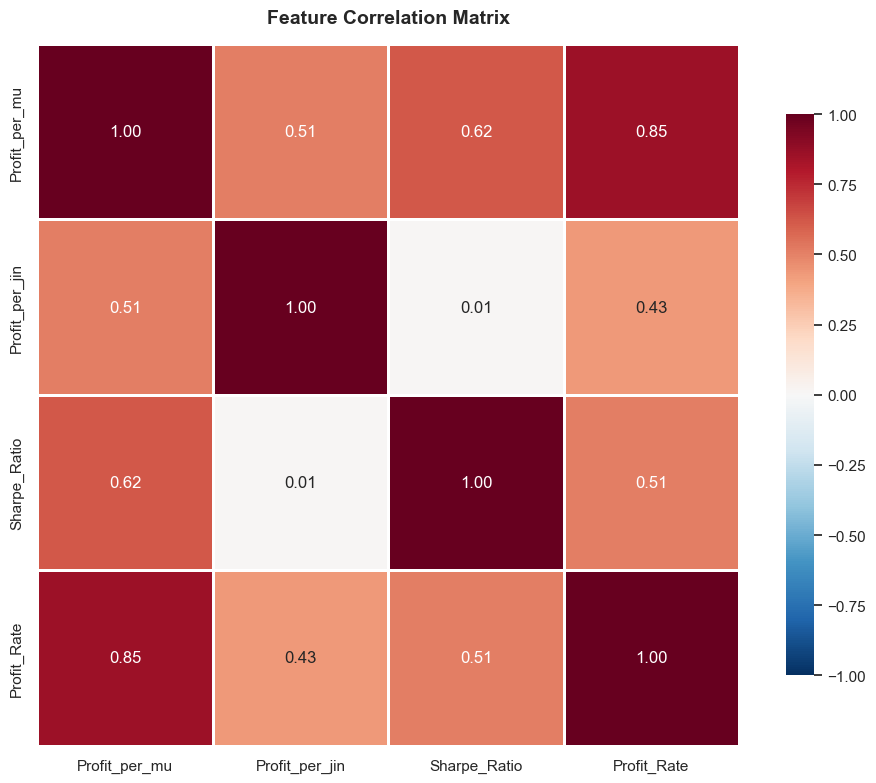

In [4]:
corr_matrix = df[indicators].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

## 4. Feature Selection

Remove two features due to correlation and conceptual issues:

**Removed:**
- `Revenue_Cost_Ratio` - Perfect correlation with `Profit_Rate` ($R = K + 1$)
- `Profit_Rate` - Relative metric that masks absolute profit differences (e.g., treats 4k and 90k profits as "similar" if ROI is close)

**Selected:**
1. `Profit_per_mu` - Absolute profitability
2. `Profit_per_jin` - Unit efficiency
3. `Sharpe_Ratio` - Risk-adjusted return

Focus on absolute values rather than cost-relative ratios for more meaningful crop groupings.

In [5]:
selected_features = ['Profit_per_mu', 'Profit_per_jin',  'Sharpe_Ratio']
features_df = df[selected_features].copy()

print(f"Selected {len(selected_features)} features for clustering")
print(f"Max correlation: {features_df.corr().abs().where(~np.eye(len(selected_features), dtype=bool)).max().max():.3f}")

Selected 3 features for clustering
Max correlation: 0.621


## 5. Robust Scaling

Use RobustScaler instead of StandardScaler to handle extreme outliers:

$$x_{scaled} = \frac{x - \text{median}}{\text{IQR}}$$

**Why:** Z-score normalization is sensitive to outliers. When one crop has 284k yuan/mu profit, it inflates standard deviation and compresses differences between moderate values (4k vs 90k both become ~0).

RobustScaler uses median and IQR, making it resistant to extremes while preserving meaningful differences in the normal range.

In [6]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_features = scaler.fit_transform(features_df)

# Verify scaling
scaled_df = pd.DataFrame(scaled_features, columns=selected_features)
print("\nRobust Scaled Features (median ≈ 0):")
print(scaled_df.describe().loc[['50%', '25%', '75%']].round(3))


Robust Scaled Features (median ≈ 0):
     Profit_per_mu  Profit_per_jin  Sharpe_Ratio
50%          0.000           0.000         0.000
25%         -0.421          -0.526        -0.293
75%          0.579           0.474         0.707


## 6. Optimal Cluster Selection

**Goal:** Determine the optimal number of clusters ($k$) that best represents natural groupings in the data.

**Method: Silhouette Score**

For each sample $i$, the silhouette coefficient is:

$$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

Where:
- $a(i)$ = mean distance to other samples in the same cluster (cohesion)
- $b(i)$ = mean distance to samples in the nearest different cluster (separation)

**Interpretation:**
- $s(i) \approx 1$: Well-clustered (far from neighboring clusters)
- $s(i) \approx 0$: On the boundary between clusters
- $s(i) < 0$: Possibly assigned to wrong cluster

Average silhouette score ranges:
- $> 0.7$: Strong structure
- $0.5 - 0.7$: Reasonable structure
- $< 0.5$: Weak structure

In [7]:
k_range = range(4, 107)
silhouette_scores = []
ch_scores = []

for k in k_range:
    Z = sch.linkage(scaled_features, method='ward')
    labels = sch.fcluster(Z, k, criterion='maxclust')
    silhouette_scores.append(silhouette_score(scaled_features, labels))

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k = {optimal_k}")
print(f"  Silhouette Score: {max(silhouette_scores):.3f}")


Optimal k = 4
  Silhouette Score: 0.751


## 7. Hierarchical Clustering

**Ward Linkage Method:**

Ward's method minimizes the within-cluster variance when merging clusters. At each step, it merges the pair of clusters that leads to minimum increase in total within-cluster variance:

$$\Delta(A, B) = \sum_{i \in A \cup B} \|x_i - \mu_{A \cup B}\|^2 - \sum_{i \in A} \|x_i - \mu_A\|^2 - \sum_{i \in B} \|x_i - \mu_B\|^2$$

Where $\mu$ denotes the centroid of a cluster.

**Why Ward?** It tends to create compact, spherical clusters and works well with Euclidean distance.

We use the optimal $k$ determined in the previous step.

In [8]:
# Perform clustering with optimal k
Z = sch.linkage(scaled_features, method='ward')
n_clusters = optimal_k
cluster_labels = sch.fcluster(Z, n_clusters, criterion='maxclust')

# Add to dataframe
df['Cluster'] = cluster_labels

# Calculate metrics
sil_score = silhouette_score(scaled_features, cluster_labels)
ch_score = calinski_harabasz_score(scaled_features, cluster_labels)

print(f"\nClustering Results (k={n_clusters}):")
print(f"  Silhouette Score: {sil_score:.3f}")
print(f"  Calinski-Harabasz: {ch_score:.1f}")
print(f"\nCluster Sizes:")
print(df['Cluster'].value_counts().sort_index())


Clustering Results (k=4):
  Silhouette Score: 0.751
  Calinski-Harabasz: 251.3

Cluster Sizes:
Cluster
1     5
2    97
3     3
4     2
Name: count, dtype: int64


## 8. Dendrogram Visualization

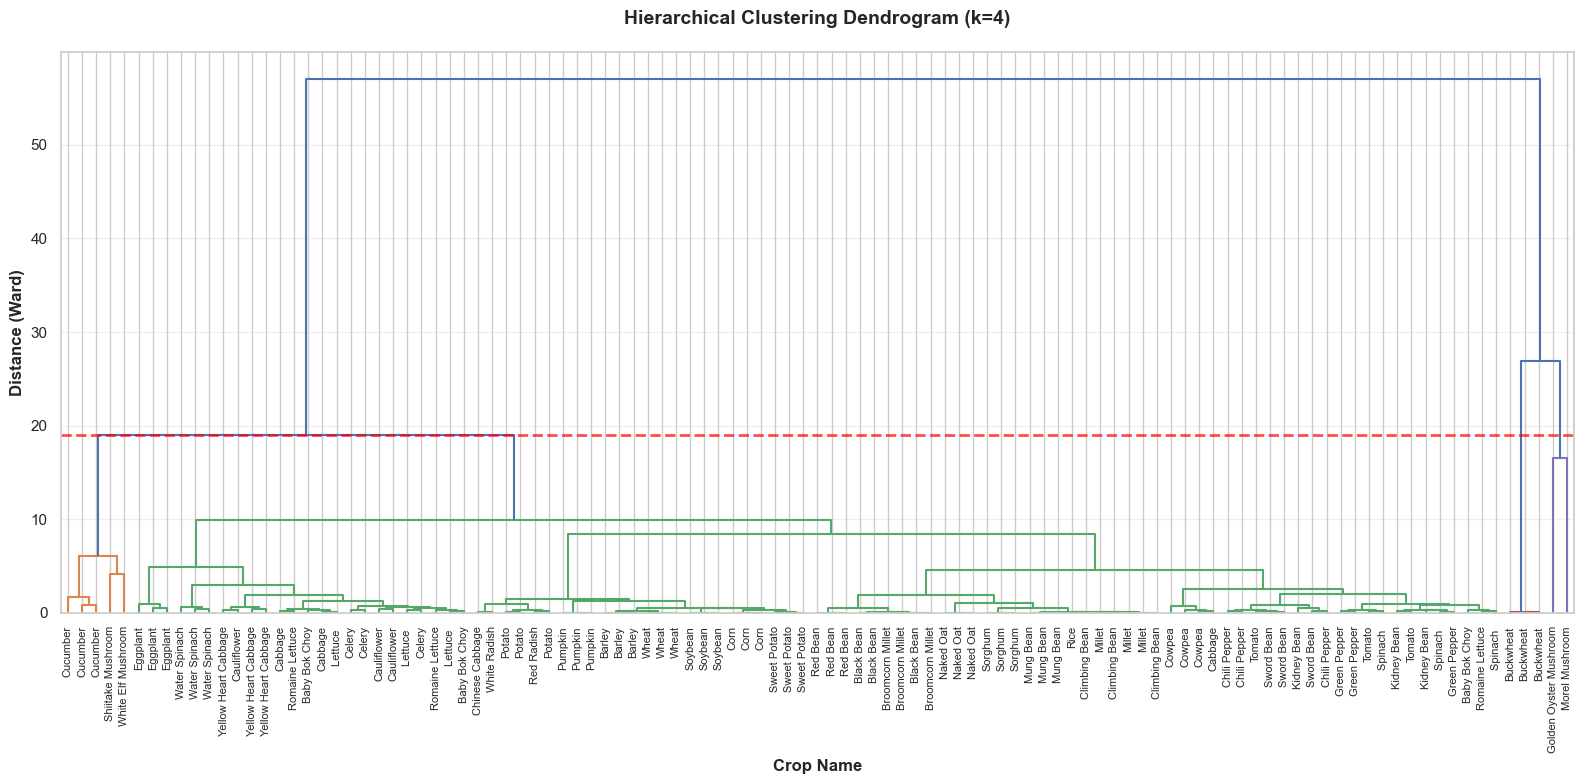

In [9]:
plt.figure(figsize=(16, 8))

dendrogram = sch.dendrogram(
    Z,
    labels=df['Crop Name'].values,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=Z[-(n_clusters-1), 2]
)

plt.axhline(y=Z[-(n_clusters-1), 2], color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.title(f'Hierarchical Clustering Dendrogram (k={n_clusters})', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Crop Name', fontsize=12, fontweight='bold')
plt.ylabel('Distance (Ward)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 9. Cluster Characterization

Analyze the economic profile of each cluster.

In [10]:
# Summary statistics by cluster
cluster_summary = df.groupby('Cluster')[selected_features].mean().round(2)
print("\nCluster Means:")
print(cluster_summary)

# Assign class labels based on profit
profit_ranking = df.groupby('Cluster')['Profit_per_mu'].mean().sort_values(ascending=False)
cluster_to_class = {old: new for new, old in enumerate(profit_ranking.index, 1)}
df['Class'] = df['Cluster'].map(cluster_to_class)

print("\nCluster → Class Mapping (by profit):")
for cluster, class_label in cluster_to_class.items():
    mean_profit = profit_ranking[cluster]
    print(f"  Cluster {cluster} → Class {class_label} (Profit: {mean_profit:,.0f} yuan/mu)")


Cluster Means:
         Profit_per_mu  Profit_per_jin  Sharpe_Ratio
Cluster                                             
1            103230.00           11.03      42289.17
2             12884.86            4.90       7556.69
3              3850.00           36.66        192.50
4            187250.00           73.45      10608.33

Cluster → Class Mapping (by profit):
  Cluster 4 → Class 1 (Profit: 187,250 yuan/mu)
  Cluster 1 → Class 2 (Profit: 103,230 yuan/mu)
  Cluster 2 → Class 3 (Profit: 12,885 yuan/mu)
  Cluster 3 → Class 4 (Profit: 3,850 yuan/mu)


## 10. PCA Visualization

Our data has 4 dimensions, but we can use **Principal Component Analysis (PCA)** to reduce it to 3 dimensions for visualization.

PCA finds orthogonal directions (principal components) that capture maximum variance in the data:

$$\mathbf{PC} = \mathbf{X} \mathbf{W}$$

Where:
- $\mathbf{X}$ = standardized feature matrix
- $\mathbf{W}$ = eigenvectors of covariance matrix (sorted by eigenvalue)
- First PC captures most variance, second PC captures second most, etc.

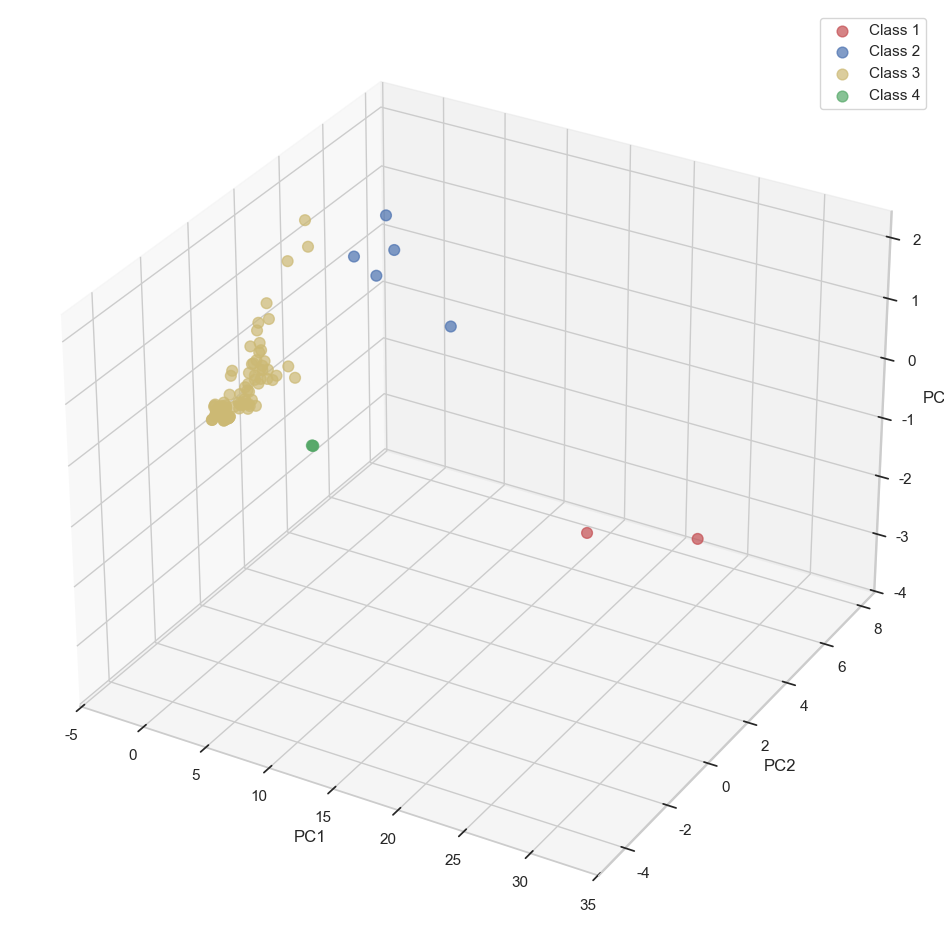

In [14]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
features_3d = pca_3d.fit_transform(scaled_features)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

colors = ['r', 'b', 'y', 'g']
for i in range(1, 5):
    mask = df['Class'] == i
    ax.scatter(features_3d[mask, 0], features_3d[mask, 1], features_3d[mask, 2],c=colors[i-1], label=f'Class {i}', s=60, alpha=0.7)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## 11. Representative Crops

Identify typical crops in each class.

In [162]:
for class_label in sorted(df['Class'].unique()):
    class_data = df[df['Class'] == class_label]
    print(f"\nClass {class_label} (n={len(class_data)})")
    all_crops = class_data.sort_values(by='Profit_per_mu', ascending=False)

    for _, row in all_crops.iterrows():
        name = row.get('Crop Name', row.get('Crop_Name', 'Unknown')) 
        print(f"{name:25s} ({row['Plot Type']:20s}): {row['Profit_per_mu']:9,.0f} yuan/mu")


Class 1 (n=2)
Golden Oyster Mushroom    (Regular Greenhouse  ):   284,500 yuan/mu
Morel Mushroom            (Regular Greenhouse  ):    90,000 yuan/mu

Class 2 (n=5)
White Elf Mushroom        (Regular Greenhouse  ):   150,000 yuan/mu
Cucumber                  (Smart Greenhouse    ):   109,550 yuan/mu
Cucumber                  (Regular Greenhouse  ):   101,500 yuan/mu
Cucumber                  (Irrigated Land      ):    81,100 yuan/mu
Shiitake Mushroom         (Regular Greenhouse  ):    74,000 yuan/mu

Class 3 (n=97)
Water Spinach             (Smart Greenhouse    ):    53,900 yuan/mu
Water Spinach             (Regular Greenhouse  ):    49,000 yuan/mu
Eggplant                  (Smart Greenhouse    ):    44,880 yuan/mu
Eggplant                  (Regular Greenhouse  ):    41,600 yuan/mu
Water Spinach             (Irrigated Land      ):    40,900 yuan/mu
Eggplant                  (Irrigated Land      ):    33,200 yuan/mu
Cabbage                   (Smart Greenhouse    ):    28,130 yuan/mu
Co

## 13. Export Results

Save clustered data for optimization model (Task 3).

In [163]:
df.to_csv('clustered_data.csv', index=False, encoding='utf-8')
print(f"\nClustered data saved: {len(df)} rows, {len(df.columns)} columns")


Clustered data saved: 107 rows, 19 columns
